We want to find the optimal step size for the 2-D bier model. Compare both derivatives and integrated dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import timeit

In [2]:
start_time = timeit.default_timer()
with open('bier_search.pkl', 'rb') as file:
    bier = pickle.load(file)
elapsed_time = timeit.default_timer() - start_time
print(elapsed_time)
bier.keys()

dict_keys([0.6, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001])

Now we are ready to create the training dataset by integrating the above system of equations to obtain the measurements. We also introduce a Gaussian noise to the dataset.

In [6]:
# compute the error for every time step (integrated dynamics)
error_dict = {}

for key, value in bier.items():
    data = value['data']
    pred = value['pred']
    time_points = value['t']
    
    #normalized L2-norm
    error_x = np.linalg.norm(data[:,0] - pred[:,0], 2)/np.linalg.norm(data[:,0], 2)
    error_y = np.linalg.norm(data[:,1] - pred[:,1], 2)/np.linalg.norm(data[:,1], 2)
    
    error_dict[key] = (error_x, error_y)
    
error_dict

{0.6: (0.9768508220511088, 0.547733435894505),
 0.2: (135.58453594152604, 100.4208740798013),
 0.1: (109.98388521708097, 60.32595779919513),
 0.05: (1.0027781010897578, 0.5528010235891208),
 0.02: (15.83493192837429, 11.522523744399486),
 0.01: (1.0821839361590468, 0.6036484738444193),
 0.005: (107.23220208861844, 83.82718128745809),
 0.001: (0.9148050086822698, 0.594999099022972)}

In [15]:
# compute the error for every time step (derivatives)
# pred1 version -- using ground truth as input
error1_dict = {}

for key, value in bier.items():
    data = np.array(value['f_data'])
    pred = np.array(value['f_pred1'])
    time_points = value['t']
    
    #normalized L2-norm
    error_x = np.linalg.norm(data[:,0] - pred[:,0], 2)/np.linalg.norm(data[:,0], 2)
    error_y = np.linalg.norm(data[:,1] - pred[:,1], 2)/np.linalg.norm(data[:,1], 2)
    
    error1_dict[key] = (error_x, error_y)
    
error1_dict

{0.6: (0.024522923156888293, 0.009751613055922904),
 0.2: (0.016051887936550473, 0.009675217464687665),
 0.1: (0.018330348350603706, 0.012141031543368968),
 0.05: (0.014716019013490584, 0.00923387217662809),
 0.02: (0.015313531059687026, 0.010769690595779507),
 0.01: (0.016316589715320642, 0.011007261180989245),
 0.005: (0.02070119610011944, 0.014548104931231121),
 0.001: (0.026327184797684738, 0.01652694953719881)}

In [16]:
# compute the error for every time step (derivatives)
# pred2 version -- using predictions as input
error2_dict = {}

for key, value in bier.items():
    data = np.array(value['f_data'])
    pred = np.array(value['f_pred2'])
    time_points = value['t']
    
    #normalized L2-norm
    error_x = np.linalg.norm(data[:,0] - pred[:,0], 2)/np.linalg.norm(data[:,0], 2)
    error_y = np.linalg.norm(data[:,1] - pred[:,1], 2)/np.linalg.norm(data[:,1], 2)
    
    error2_dict[key] = (error_x, error_y)
    
error2_dict

{0.6: (1.1089893302261586, 1.1597932791094219),
 0.2: (3.5863524292446796, 7.32708250750499),
 0.1: (2.8441608879989424, 4.327950214259909),
 0.05: (1.1521660113359684, 1.1960507103974443),
 0.02: (1.646135028992749, 2.4402798440065974),
 0.01: (1.2495550584478532, 1.2941229590829166),
 0.005: (2.802799115965341, 6.005497946518887),
 0.001: (1.015039924118619, 1.0378004866610187)}

In [22]:
a = np.array([0, 2])
b = np.array([1, 1])
np.max([a, b], axis=0)
np.zeros(2)

array([0., 0.])

In [12]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    I think this is the best implementation (more robust than flatten())
    """
    return np.ravel(model.predict(x.reshape(1,-1)))
    
predicted_traj = odeint(lambda x, t: ml_f(x), x0, time_points)

In [13]:
with open('test_pred.npy', 'wb') as file:
    np.save(file, predicted_traj)

predicted_traj

array([[ 2.        ,  0.        ],
       [ 1.99085224, -0.15625392],
       [ 1.98163791, -0.30883017],
       ...,
       [ 1.56225783, -0.30963968],
       [ 1.56225783, -0.30963968],
       [ 1.56225783, -0.30963968]])

# 2. Validation

You may need to terminate kernel to run the codes below. There are OpenMP issues with TensorFlow 2.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

time_points = np.arange(0,25,0.01)
with open('test_pred.npy', 'rb') as file:
    test_pred = np.load(file)

def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

Text(0.5, 1.0, 'Trajectories of 2D Cubic Harmonic Oscillator')

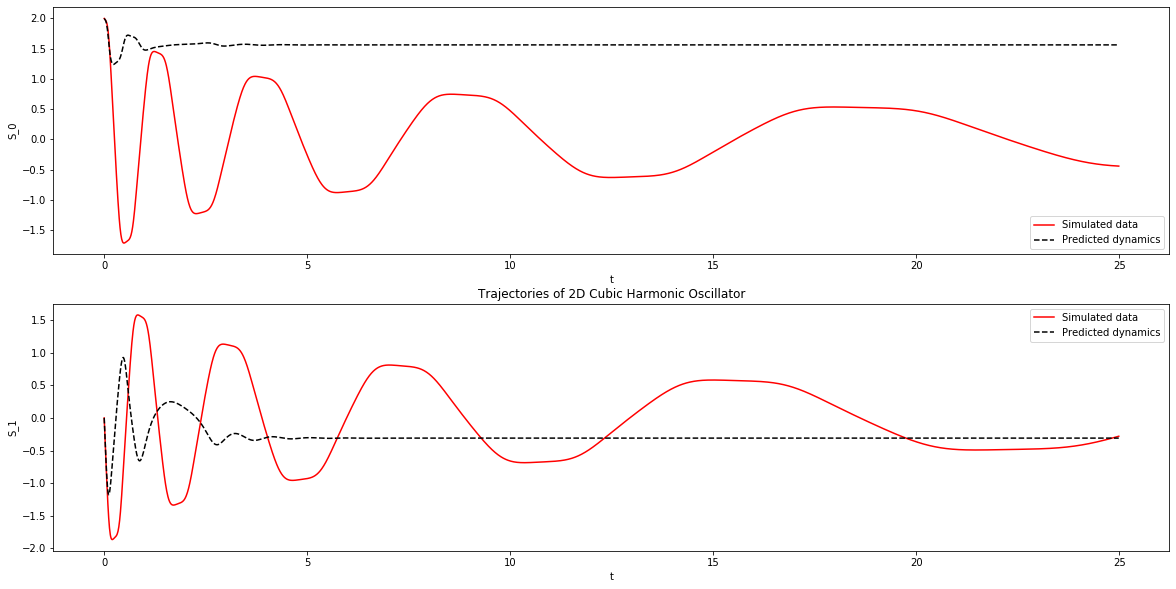

In [2]:

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, simulated_x[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, test_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Cubic Harmonic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Cubic Harmonic Oscillator')

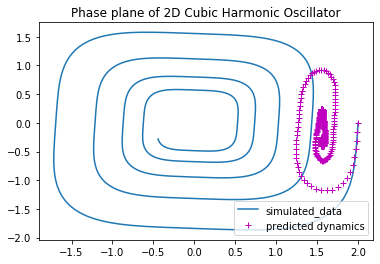

In [3]:
# Phase plane

plt.plot(simulated_x[:,0], simulated_x[:,1], label='simulated_data')
plt.legend()
plt.plot(test_pred[:,0], test_pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Cubic Harmonic Oscillator')